# ニュース配信の分類

Reutersのニュース配信を46種類のトピックに分類するネットワークを構築する。

## Reutersデータセット

Reutersによって配信されたニュース記事とそれらのトピックを集めたデータセットを取得する。

In [2]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

num_words=10000で出現頻度が高い10000語の単語だけを残す。
トレーニングデータセットはサンプル8982
テストデータセットはサンプル2246

In [3]:
len(train_data)

8982

In [4]:
len(test_data)

2246

各サンプルは整数（単語のインデックス）のリストになっている。

In [5]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

この整数リストを単語に戻してみるとこうなる

In [7]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [8]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

トピックラベルは0~45の整数

In [8]:
train_labels[10]

3

## データの準備

Wインデックス化されたニュースをテンソルに変換する。

In [10]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

ラベルのベクトル化はone-hotエンコーディングを用いる。one-hotエンコーディングの定義はこちら

In [12]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# Our vectorized training labels
one_hot_train_labels = to_one_hot(train_labels)
# Our vectorized test labels
one_hot_test_labels = to_one_hot(test_labels)

Kerasにはこの定義と同じことを行う方法が組み込まれている。

In [13]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## ニューラルネットワークの構築

出力クラスの値が2から46に増えている。

In [15]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

今回のネットワークアーキテクチャの注意点：
ネットワーク最後の層はサイズ46の全結合層である。つまり入力サンプルごとに46次元の出力ベクトルを生成する。
最後の層は活性化関数としてsoftmax層を使っている。
つまり、このネットワークの出力は46種類の出力ベクトルであり、46個の確率値を合計すると１になる。

この問題の場合、最適な損失関数はcategorical_crossentropy

In [16]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## アプローチの検証

トレーニングセットのうち1000を検証用に分けておく。

In [17]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

512サンプルのミニバッチで20エポックの訓練を行う

In [18]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))


Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 4s 461us/step - loss: 2.5542 - accuracy: 0.4992 - val_loss: 1.6646 - val_accuracy: 0.6510
Epoch 2/20
7982/7982 [==============================] - 2s 211us/step - loss: 1.3809 - accuracy: 0.7115 - val_loss: 1.3018 - val_accuracy: 0.7150
Epoch 3/20
7982/7982 [==============================] - 1s 169us/step - loss: 1.0344 - accuracy: 0.7757 - val_loss: 1.1228 - val_accuracy: 0.7600
Epoch 4/20
7982/7982 [==============================] - 1s 177us/step - loss: 0.8080 - accuracy: 0.8272 - val_loss: 1.0376 - val_accuracy: 0.7720
Epoch 5/20
7982/7982 [==============================] - 2s 224us/step - loss: 0.6469 - accuracy: 0.8617 - val_loss: 0.9964 - val_accuracy: 0.7830
Epoch 6/20
7982/7982 [==============================] - 1s 163us/step - loss: 0.5186 - accuracy: 0.8872 - val_loss: 0.9352 - val_accuracy: 0.8110
Epoch 7/20
7982/7982 [==============================] - 1s 167us/step - los

損失値とエポックの関係をプロットする

findfont: Font family ['Osaka'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Osaka'] not found. Falling back to DejaVu Sans.


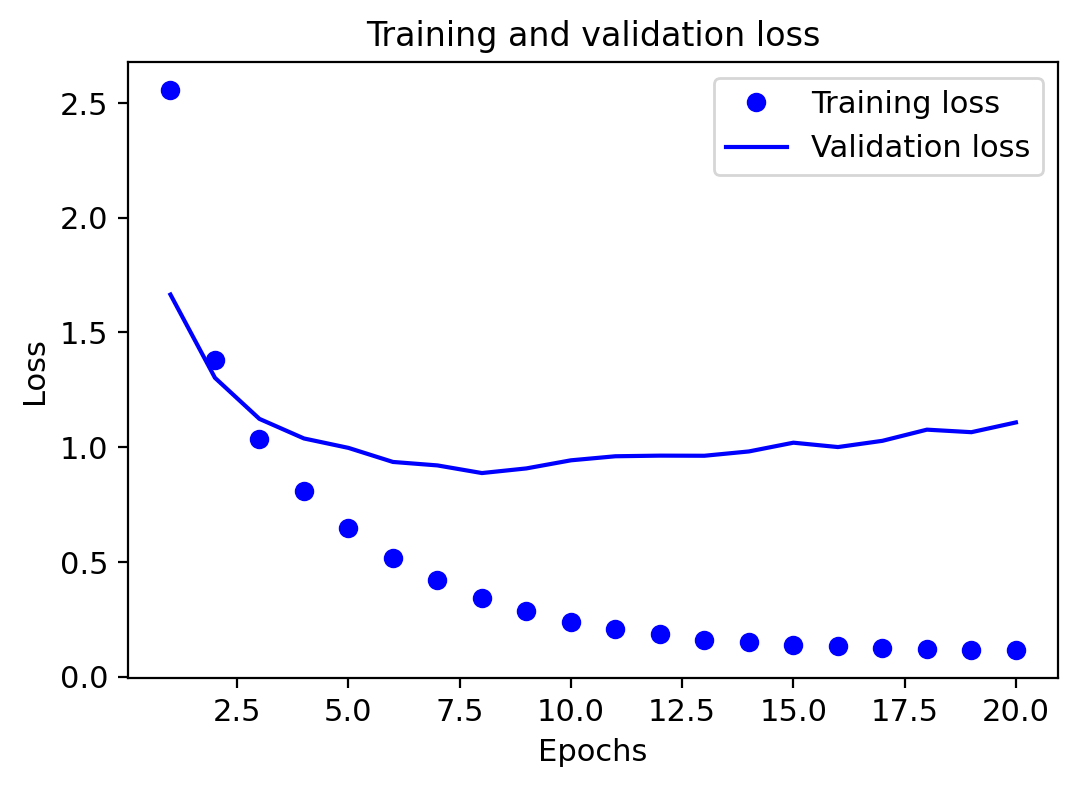

In [19]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

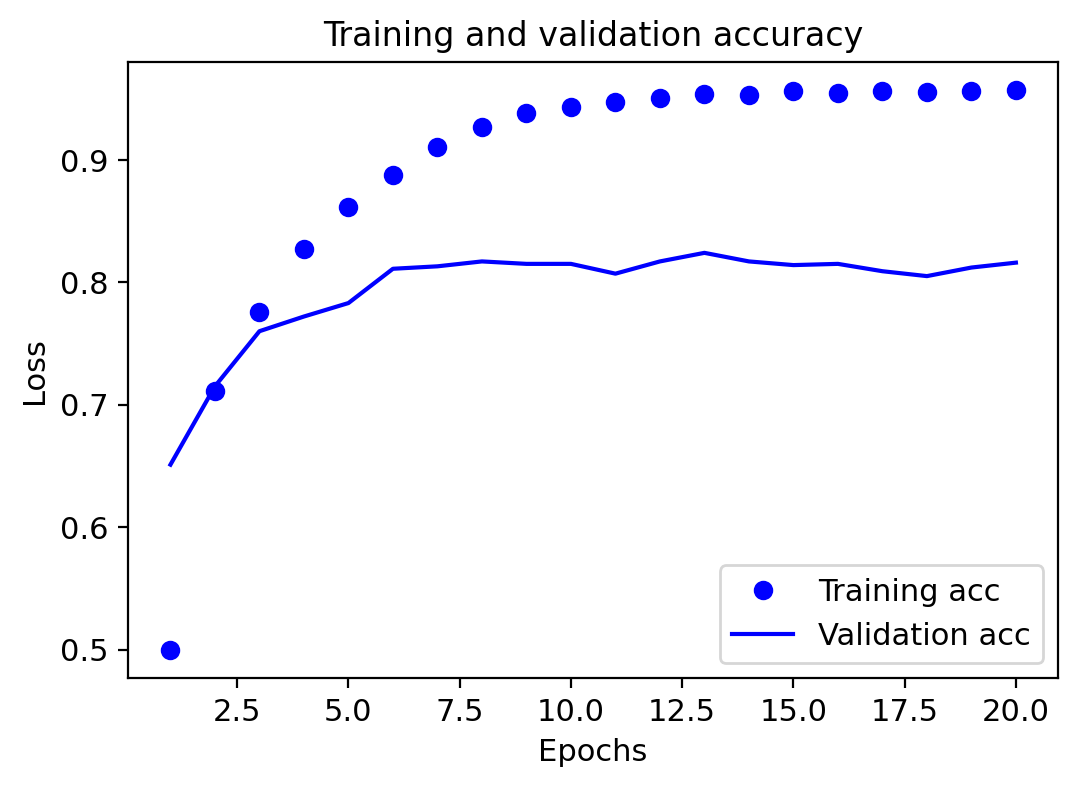

In [21]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

トレーニングデータでの損失値がエポックごとに小さくなっていき、正解率が向上していることがわかる。
一方、テストデータセットに対しては、8つ目のエポック以降は損失値の減少率も正解率の増加率も伸び悩んでいるため、8エポック以降は過学習（overfitting）が起きていることを示している。

したがって、今回は過学習を回避するために訓練回数（エポック）を8回で止めるのが適当であろう。

In [22]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=8,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/8
7982/7982 [==============================] - 4s 526us/step - loss: 2.5517 - accuracy: 0.5261 - val_loss: 1.6380 - val_accuracy: 0.6710
Epoch 2/8
7982/7982 [==============================] - 2s 296us/step - loss: 1.3549 - accuracy: 0.7165 - val_loss: 1.2763 - val_accuracy: 0.7200
Epoch 3/8
7982/7982 [==============================] - 2s 253us/step - loss: 1.0137 - accuracy: 0.7813 - val_loss: 1.1373 - val_accuracy: 0.7440
Epoch 4/8
7982/7982 [==============================] - 2s 235us/step - loss: 0.8010 - accuracy: 0.8294 - val_loss: 1.0256 - val_accuracy: 0.7750
Epoch 5/8
7982/7982 [==============================] - 2s 205us/step - loss: 0.6419 - accuracy: 0.8632 - val_loss: 0.9583 - val_accuracy: 0.8000
Epoch 6/8
7982/7982 [==============================] - 2s 204us/step - loss: 0.5133 - accuracy: 0.8914 - val_loss: 0.9540 - val_accuracy: 0.7880
Epoch 7/8
7982/7982 [==============================] - 2s 203us/step - loss: 0.418

In [23]:
results

[0.9776566763170468, 0.7818343639373779]


Our approach reaches an accuracy of ~78%. With a balanced binary classification problem, the accuracy reached by a purely random classifier 
would be 50%, but in our case it is closer to 19%, so our results seem pretty good, at least when compared to a random baseline:

In [24]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.19902048085485308

## 学習済みネットワークで予測値を生成

訓練が完了したらpredictメソッドを呼び出してレビューが肯定的として分類される尤度を生成する。

In [26]:
predictions = model.predict(x_test)

predictionsの各エントリは長さがが46のベクトルである。

In [27]:
predictions[0].shape

(46,)

The coefficients in this vector sum to 1:

In [28]:
np.sum(predictions[0])

0.99999994

The largest entry is the predicted class, i.e. the class with the highest probability:

In [30]:
np.argmax(predictions[0])

3

## ラベルと損失値を処理する別の方法

ラベルを整数値のテンソルとしてキャストしてラベルをエンコードしてみよう。

In [31]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

このアプローチで変わるのは損失関数になる。
ラベルが整数値である場合は`sparse_categorical_crossentropy`を使う。

In [32]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

## 十分な大きさの中間層を持つことの重要性

46次元よりもずっと小さい中間層を使用して情報ボトルネックが生じる場合について確認してみよう。

In [33]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 3s 430us/step - loss: 2.9124 - accuracy: 0.3855 - val_loss: 2.3350 - val_accuracy: 0.3980
Epoch 2/20
7982/7982 [==============================] - 2s 289us/step - loss: 2.0422 - accuracy: 0.4602 - val_loss: 1.9243 - val_accuracy: 0.4700
Epoch 3/20
7982/7982 [==============================] - 2s 297us/step - loss: 1.5448 - accuracy: 0.5948 - val_loss: 1.4912 - val_accuracy: 0.6330
Epoch 4/20
7982/7982 [==============================] - 2s 281us/step - loss: 1.1791 - accuracy: 0.6839 - val_loss: 1.3582 - val_accuracy: 0.6480
Epoch 5/20
7982/7982 [==============================] - 2s 283us/step - loss: 1.0329 - accuracy: 0.7155 - val_loss: 1.3227 - val_accuracy: 0.6560
Epoch 6/20
7982/7982 [==============================] - 2s 276us/step - loss: 0.9322 - accuracy: 0.7398 - val_loss: 1.3385 - val_accuracy: 0.6850
Epoch 7/20
7982/7982 [==============================] - 2s 286us/step - loss


Our network now seems to peak at ~71% test accuracy, a 8% absolute drop. This drop is mostly due to the fact that we are now trying to 
compress a lot of information (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space that is 
too low-dimensional. The network is able to cram _most_ of the necessary information into these 8-dimensional representations, but not all 
of it.

## Further experiments

* Try using larger or smaller layers: 32 units, 128 units...
* We were using two hidden layers. Now try to use a single hidden layer, or three hidden layers.

## Wrapping up


Here's what you should take away from this example:

* If you are trying to classify data points between N classes, your network should end with a `Dense` layer of size N.
* In a single-label, multi-class classification problem, your network should end with a `softmax` activation, so that it will output a 
probability distribution over the N output classes.
* _Categorical crossentropy_ is almost always the loss function you should use for such problems. It minimizes the distance between the 
probability distributions output by the network, and the true distribution of the targets.
* There are two ways to handle labels in multi-class classification:
    ** Encoding the labels via "categorical encoding" (also known as "one-hot encoding") and using `categorical_crossentropy` as your loss 
function.
    ** Encoding the labels as integers and using the `sparse_categorical_crossentropy` loss function.
* If you need to classify data into a large number of categories, then you should avoid creating information bottlenecks in your network by having 
intermediate layers that are too small.